In [1]:
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# 1. Data Preprocessing

In [2]:
kaggle.api.authenticate()
kaggle_dataset = 'jruvika/fake-news-detection'
kaggle.api.dataset_download_files(kaggle_dataset, path='data/', unzip=True)

In [3]:
# Read in data
# 1 if the article is true, 0 if the article is fake
df = pd.read_csv('data/data.csv')
df = df.dropna() # TODO: explore NAs
df.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


# 2. Data Analysis

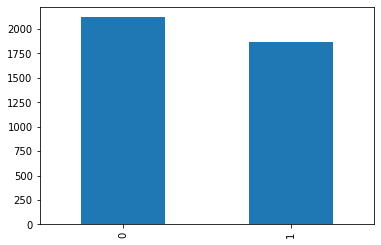

In [4]:
df.Label.value_counts().plot.bar();

# 3. Feature Selection

In [5]:
y = df.Label
X = df.drop(['Label', 'URLs'], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True)

#  4. Modeling

In [7]:
models = [MultinomialNB, LogisticRegression]
for model in models:
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', model()),
    ])

    text_clf.fit(X_train.Body, y_train)

    # Save model
    dump(text_clf, 'models/{}_model.joblib'.format(model.__name__))

# 5. Evaluation 

In [8]:
for model in models:
    loaded_text_clf = load('models/{}_model.joblib'.format(model.__name__)) 
    predicted = loaded_text_clf.predict(X_test.Body)
    print("Model: ", model.__name__)
    print(metrics.classification_report(y_test, predicted))

Model:  MultinomialNB
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       663
           1       0.89      0.97      0.92       534

    accuracy                           0.93      1197
   macro avg       0.93      0.93      0.93      1197
weighted avg       0.93      0.93      0.93      1197

Model:  LogisticRegression
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       663
           1       0.94      0.97      0.96       534

    accuracy                           0.96      1197
   macro avg       0.96      0.96      0.96      1197
weighted avg       0.96      0.96      0.96      1197



# 6. Extract Article from URL 

In [9]:
import newspaper

In [10]:
url = 'https://www.bbc.com/news/world-us-canada-53507660'
article = newspaper.Article(url) 
article.download()
article.parse()

In [11]:
article.text

'Media playback is unsupported on your device Media caption Trump: Americans should walk city streets free from violence and fear\n\nPresident Donald Trump is to send "a surge" of federal security forces to US cities in a crackdown on crime.\n\nChicago and two other Democratic-run cities are being targeted in the Republican president\'s move, amid a spike in violence.\n\nBut federal deployments in Portland, Oregon, amid ongoing unrest have been controversial. The city\'s mayor was among those tear-gassed at a protest.\n\nLaw and order has become a key plank of Mr Trump\'s re-election bid in November.\n\nSince the death on 25 May of an unarmed black man, George Floyd, in police custody in Minneapolis, Minnesota, there have been protests - sometimes descending into civil disorder - in scores of US cities.\n\nIn Portland, which has seen more than 50 days of demonstrations, Mayor Ted Wheeler was tear-gassed by federal agents while attending the city\'s protest on Wednesday night.\n\nSpeaki

In [12]:
test_probabilities = loaded_text_clf.predict_proba([article.text])[0]

([<matplotlib.patches.Wedge at 0x1a1f6ea350>,
 [Text(0.8450889826987295, 0.7041481458622374, 'Fake'),
  Text(-0.8450889167716185, -0.704148224985175, 'Real')],
 [Text(0.46095762692657966, 0.38408080683394763, '22.1%'),
  Text(-0.46095759096633726, -0.38408084999191366, '77.9%')])

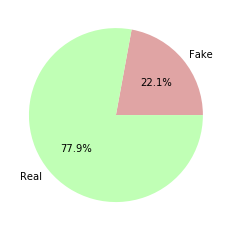

In [13]:
plt.pie(test_probabilities, 
        labels=['Fake', 'Real'], 
        colors=['#e0a4a4', '#c0ffb5'], 
        autopct='%1.1f%%',
       )